# Self-Taught Learning

## Auxiliary functions

In [162]:
#Error function to calculate mis-classification
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

## Accuracy function 
accuracy <- function(Y, T){
    return (100*sum(Y==T)/dim(T)[1])
}

## Task - I: Loading libraries and data files

In [163]:
# loading libraries
options(warn=-1)
library(h2o)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)

library(ggplot2)
library(reshape)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         19 hours 25 minutes 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.9 
    H2O cluster version age:    12 days  
    H2O cluster name:           H2O_started_from_R_kaush_jro703 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.14 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.3 (2017-11-30) 



In [164]:
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = 'C:/Users/kaush/Desktop/SEM-3/DAA/Assignment2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/kaush/Desktop/SEM-3/DAA/Assignment2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/kaush/Desktop/SEM-3/DAA/Assignment2/Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## Task - II: Training an Autoencoder with increasing neurons in the hidden layer
## Task - III: For each model in Task - II, record the reconstruction error
## Task - V: Add the output of the middle layer as extra features to the original feature set,: Add the output of the middle layer as extra features to the original feature set and train 3-layer NN


We run the Task-2,3, and 5 together to optimize the execution time. We train the autoencoder using h20.deeplearning for different number of neurons in the hidden layer. Then, we calculate the reconstruction errors. Next, we add the output of the middle layer as extra features to the original feature and train 3-layer NN. Then, we calculate the mis-classification errors for different number of extra features.

In [165]:
# create a sequence of hidden nodes
hid_nodes <- seq(from = 20, to = 500,by = 20)

#create a data frame to store reconstruction errors
rec_errors <- as.data.frame(matrix(0, nrow = length(hid_nodes), ncol = 2))
# naming columns for the reconstruction errors dataframe
colnames(rec_errors) <- c('Num_hidden_nodes','Rec_Error')

#create a data frame to store classification test error
class_test_errors <- as.data.frame(matrix(0, nrow = length(hid_nodes), ncol = 2))
colnames(class_test_errors) <- c('Num_extra_features','Classification_test_error')

#increasing the number of nodes in the hidden layer in each iteration
for(n in hid_nodes){
    
    # Task-II: building an autoencoder model
    encoder_model <- h2o.deeplearning(    
    x = 1:ncol(train.frame), # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(n), # number of layers and their units
    epochs = 100, # maximum number of epochs  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    
    # Task-III: Recording the reconstruction errors
    #save the number of hidden nodes in the first column
    rec_errors[n/20,1] <- n 
    
    #calculation of reconstruction errors using h2o.anomaly and storing in respective errors dataframe
    rec_errors[n/20,2] <- mean(h2o.anomaly(encoder_model, train.frame))   
    
    # Task-V: Building augmented self taught networks
    # a: Add the output of the middle layer as extra features to the original feature set
    # Extract output of the middle layer as extra features using h2o.deepfeatures function
    extra_features = h2o.deepfeatures(encoder_model, labeled.frame[,-1], layer=1)
    combined.frame <- h2o.cbind(labeled.frame, extra_features)
    
    #b:Train the above built 3 layer NN using all the features (original + extra) i.e. combined.frame
    nn_model <- h2o.deeplearning(    
      x = 2:ncol(combined.frame), # select all pixels + extra features
      y = 1,
      training_frame = combined.frame, # specify the frame (imported file)    
      hidden = c(100), # number of layers and their units
      epochs = 50, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )
    
    # predict class labels using test.frame and built classifier
    test.predict <- h2o.predict(nn_model, test.frame)$predict
     
    # now calculate and record the test error.
    class_test_errors[n/20, 1] <- n 
    class_test_errors[n/20, 2] <- error.rate(test.frame$label, test.predict)
    
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [166]:
#displaying reconstruction errors
rec_errors
#displaying 3-NN classification test errors 
class_test_errors

Num_hidden_nodes,Rec_Error
20,0.033052840
40,0.020901814
60,0.015187131
80,0.012274414
100,0.011316649
120,0.009434102
140,0.008026671
160,0.007226092
180,0.006066900
200,0.006100284


Num_extra_features,Classification_test_error
20,0.589
40,0.571
60,0.602
80,0.548
100,0.531
120,0.547
140,0.583
160,0.563
180,0.635
200,0.635


### Plotting reconstruction errors vs number of units in the middle layer

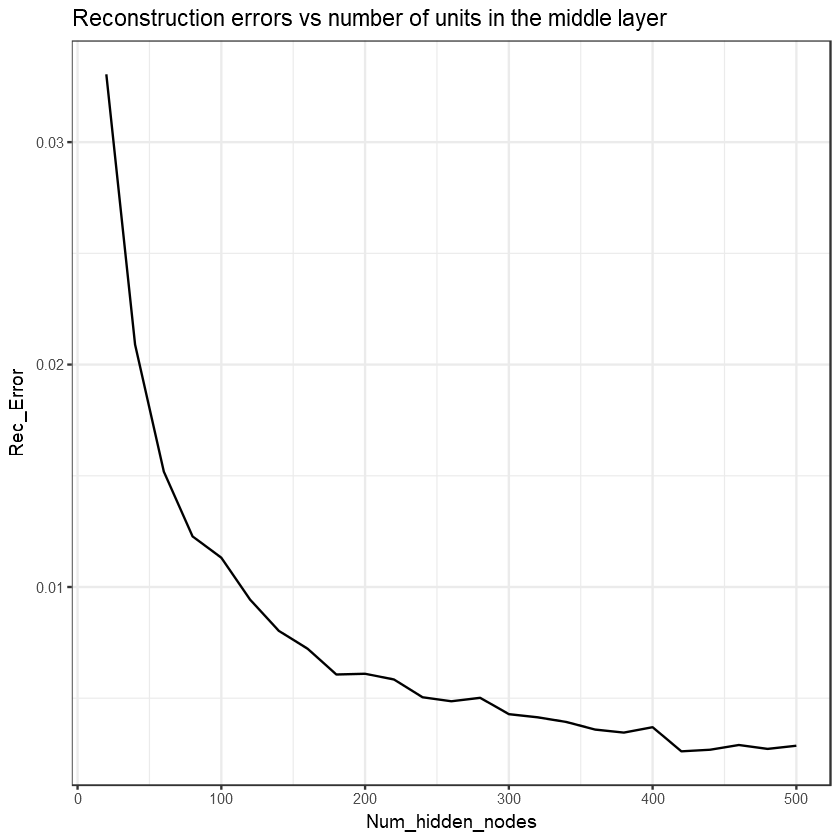

In [167]:
# plotting reconstruction errors vs number of units in the middle layer
ggplot(data=rec_errors, aes(x=Num_hidden_nodes, y=Rec_Error)) +
    ggtitle("Reconstruction errors vs number of units in the middle layer") +
    geom_line(color = "black") + theme_bw()

## Task - IV: Build a 3-layer NN classifier

In [168]:
# build a neural network classifier based on the labeled training data
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(100), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)

  |======================================================================| 100%


We predict the labels using h2o.predict function and calculate accuracy and mis-classification error of training data.

In [169]:
# predict class labels using labeled.frame and built classifier
labeled.predict <- h2o.predict(NN.model, labeled.frame)$predict
# Calculation of Accuracy of the built classifier on training data
accuracy(labeled.frame$label, labeled.predict)
# Calculation of training error of the built classifier by calling error function
error.rate(labeled.frame$label, labeled.predict)

  |======================================================================| 100%


[1] 96

[1] 0.04

We calculate the test error now.

In [170]:
# predict class labels using test.frame and built classifier
test.predict <- h2o.predict(NN.model, test.frame)$predict

# Calculation of test error by calling error function
error.rate(test.frame$label, test.predict)

  |======================================================================| 100%


[1] 0.505

## Task- VI: Plotting classification errors vs number of extra features

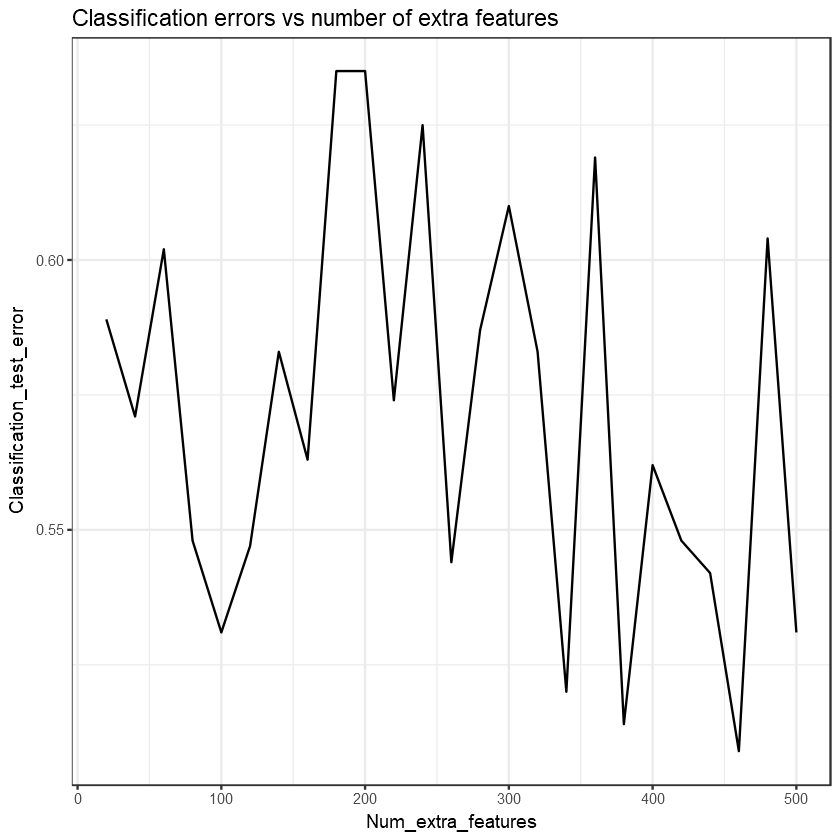

In [171]:
# Plotting classification errors vs number of extra features
ggplot(data=class_test_errors, aes(x=Num_extra_features, y=Classification_test_error)) +
   ggtitle("Classification errors vs number of extra features") +
    geom_line(color = "black") + theme_bw()

## Task - VII: Reporting Optimum number of units in the middle layer of the autoencoder in terms of reconstruction and misclassification errors

In [172]:
# calculation of minimum reconstruction error
min_rec_error <- min(rec_errors[,2])
# calculation of minimum classification error
min_class_error <- min(class_test_errors[,2])

# optimum number of units in the middle layer 
opt_num_rec <- rec_errors[rec_errors[,2] == min(rec_errors[,2]),]$Num_hidden_nodes
opt_num_class <- class_test_errors[class_test_errors[,2] == min(class_test_errors[,2]),]$Num_extra_features

In [177]:
# Minimum Reconstruction and Classification Error
cat('The minimum reconstruction error is ', min_rec_error)
cat('\n')
cat('The minimum classification error is ',min_class_error)

The minimum reconstruction error is  0.002613043
The minimum classification error is  0.509

In [178]:
# Optimum number of units in the middle layer of the autoencoder
cat('The Optimum number of units in the middle layer of the autoencoder in terms of reconstruction error is ', opt_num_rec)
cat('\n')
cat('The Optimum number of units in the middle layer of the autoencoder in terms of classification error is ',opt_num_class)

The Optimum number of units in the middle layer of the autoencoder in terms of reconstruction error is  420
The Optimum number of units in the middle layer of the autoencoder in terms of classification error is  460

## Task - VIII: Difference between Perceptron and NN

This is discussed in the PDF report. Please refer to it.